In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import gzip
import shutil

import seaborn as sns
import math

import os
import folium
import geopandas as gpd

## Import  and transform data

In [2]:
def txt_to_dataframe(FOLDER_NAME,FILE_NAME,keys_list):
    """
    This function allows to pass the txt file to a dataframe and save it as a csv file 
    - FOLDER_NAME: name of the folder in which the txt file is
    - FILE_NAME: text file with a dictionary format
    - keys_list: list of keys for the columns
    The function returns a dataframe file and save it as a csv file
    """
    dict_list = []
    newDict = {key: None for key in keys_list}
    
    FOLDER_PATH = './Data/' + FOLDER_NAME
    FILE_PATH = FOLDER_PATH + '/' + FILE_NAME + ".txt"
    CSV_FILE_PATH = FOLDER_PATH + '/' + FILE_NAME + ".csv"
    
    if os.path.exists(CSV_FILE_PATH) == False:
        with open(FILE_PATH, 'r', encoding="utf8") as f:
    
            for line in f:
                line = line.replace(u'\xa0','')
                listedline = line.split(':',1) # split around the ":" sign
        
                # take non-empty lines
                if len(listedline) > 1:
                    newDict[listedline[0]] = listedline[1].strip()
        
                # finish the dictionary for the line
                if listedline[0] == keys_list[-1]:
                    dict_list.append(newDict)
            
                    # reinitialize the dictionary for the next line
                    newDict = {key: None for key in keys_list}
    
            # transform list of dictionaries to dataframe
            df = pd.DataFrame(dict_list,columns=keys_list)
            
            # save dataframe file to a pickle file
            df.to_csv(CSV_FILE_PATH)
    
        return df
    
    else:
        
        df_csv = pd.read_csv(CSV_FILE_PATH,index_col = [0])
    
        return df_csv

In [ ]:
# read csv files

keys_reviews = (['beer_name','beer_id','brewery_name','brewery_id','style','abv','date','user_name','user_id',\
                          'appearance','aroma','palate','taste','overall','rating','text'])

df_reviews_RB = txt_to_dataframe("RateBeer","reviews",keys_reviews)
df_beers_RB = pd.read_csv("./Data/RateBeer/beers.csv")

In [28]:
# read brewery csv with api
df_breweries_RB = pd.read_csv("./Data/breweries_api_Baptiste_version.csv")
df_breweries_RB.drop('Unnamed: 0.1', axis = 1, inplace = True)
df_breweries_RB.drop('Unnamed: 0', axis = 1, inplace = True)
df_breweries_RB.rename(columns={"id": "brewery_id"}, inplace=True)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,1,NaN,NaN,2.79,4.2,3.000000,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442076,189684,Stela Selekt,1107,Stefani & Co,Pilsener,5,NaN,NaN,2.19,4.7,1.500000,NaN,0,NaN
442077,84884,Hotel Martini Donauer,9355,Hotel Martini,Pale Lager,1,NaN,NaN,2.77,NaN,2.900000,NaN,0,NaN
442078,93783,Birra Rozafa,9928,Rozafa Brewery,Pale Lager,1,NaN,NaN,2.64,NaN,2.000000,NaN,0,NaN
442079,220897,Svejk Blonde,17155,Svejk Beer Garden,Pale Lager,4,NaN,NaN,2.70,NaN,2.500000,NaN,0,NaN


In [19]:
# merge reviews and users on user id
df_reviews_beers_RB=pd.merge(df_reviews_RB, df_beers_RB[['beer_id','nbr_ratings']], how="left", on=['beer_id'])

# merge reviews and breweries on brewery id
df_all_RB = pd.merge(df_reviews_beers_RB, df_breweries_RB, how='left', on=['brewery_id'])

df_all_RB.rename(columns={"location": "brewery_location"}, inplace=True)

df_all_RB = df_all_RB.drop_duplicates(subset=['beer_id','user_name','user_id'],keep = 'first')

# keep only keys of interest
keys_to_drop = ['abv', 'appearance','aroma', 'palate', 'taste', 'text', 'date', 'user_id','user_name']
df_interest_RB= df_all_RB.drop(keys_to_drop, axis=1)
df_interest_RB.rename(columns={"nbr_ratings": "nbr_ratings_per_beer"}, inplace=True)

#keeping only beers with more than 3 reviews
df_interest_RB = df_interest_RB[df_interest_RB.nbr_ratings_per_beer>3]


In [6]:
# mean rating per brewery
df_interest_RB.groupby('brewery_id').agg('mean')['rating'].to_frame().sort_values(by='rating', ascending=False)

# mean rating per style
df_interest_RB.groupby('style').agg('mean')['rating'].to_frame().sort_values(by='rating', ascending=False)

# mean rating per style and brewery
df_interest_RB.groupby(['style','brewery_id']).agg('mean')['rating'].to_frame().sort_values(by=['style','rating'], ascending=False)

rating
style                   brewery_id          
Zwickel/Keller/Landbier 5848        4.233333
                        4659        3.900000
                        8703        3.850000
                        12178       3.833333
                        5962        3.778481
...                                      ...
Abbey Dubbel            20398       2.307143
                        22684       2.275000
                        9485        2.257143
                        5897        2.200000
                        19843       2.150000

[50643 rows x 1 columns]

In [29]:
df_interest_RB.drop(['Unnamed: 0','name'], axis = 1, inplace = True)
df_interest_RB.head()

,beer_name,beer_id,brewery_name,brewery_id,style,overall,rating,nbr_ratings_per_beer,brewery_location,nbr_beers,latitude,longitude
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,8,1.9,10,Gabon,3.0,0.303409,9.501448
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5,1.6,10,Gabon,3.0,0.303409,9.501448
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5,1.5,10,Gabon,3.0,0.303409,9.501448
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,7,1.9,10,Gabon,3.0,0.303409,9.501448
5,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,9,1.9,10,Gabon,3.0,0.303409,9.501448


In [11]:
Lat = df_interest_RB['latitude']
Lon = df_interest_RB['longitude']

## Europe

In [12]:
min_lon = -15 #-15 Europe, -5 Eq test
max_lon = 35 #35 Europe, 45 Eq test
min_lat = 30 #30 Europe, -10 Eq test
max_lat = 60 #60 Europe, 10 Eq test
res = 0.5 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

In [13]:
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

In [14]:
map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')


KeyboardInterrupt: 

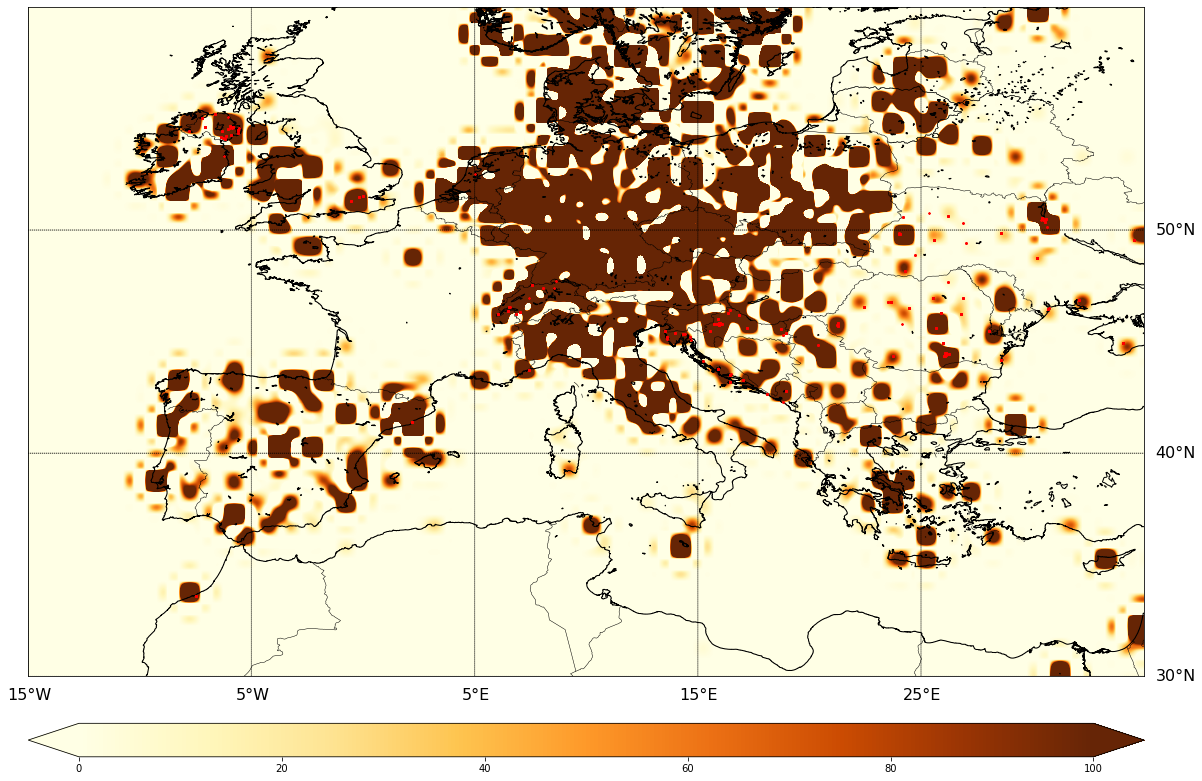

In [15]:
fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=100)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon, Lat):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)

## Switzerland

In [ ]:
min_lon = 5 #-15 Europe, -5 Eq test
max_lon = 11 #35 Europe, 45 Eq test
min_lat = 45 #30 Europe, -10 Eq test
max_lat = 48 #60 Europe, 10 Eq test
res = 0.1 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

In [ ]:
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

In [ ]:
map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')

In [ ]:
fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=500)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon, Lat):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)

In [ ]:
min_lon = 2 #-15 Europe, -5 Eq test
max_lon = 7 #35 Europe, 45 Eq test
min_lat = 49 #30 Europe, -10 Eq test
max_lat = 54 #60 Europe, 10 Eq test
res = 0.1 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

In [ ]:
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

In [ ]:
map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')

In [ ]:
fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=50)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon, Lat):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)